# Prediction of PSA levels using regression models
Data source: https://rafalab.github.io/pages/649/prostate.html

### Set up environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn import linear_model

%matplotlib inline

### Load data

In [2]:
TRAINING_SET_SIZE = 60
data = pd.read_csv('psa.txt', delimiter='\t')
del data['col'] # Delete index column
del data['train'] # Not sure what this column encodes (values in {T, F})
print("Data shape =", data.shape)
X = data.iloc[:, :-1] # Predictors 
y = data.iloc[:, -1] # Response
X_train = data.iloc[:TRAINING_SET_SIZE, :-1]
y_train = data.iloc[:TRAINING_SET_SIZE, -1]
X_test = data.iloc[TRAINING_SET_SIZE:, :-1]
y_test = data.iloc[TRAINING_SET_SIZE:, -1]
print("Columns:", data.columns.values)

Data shape = (97, 9)
Columns: ['lcavol' 'lweight' 'age' 'lbph' 'svi' 'lcp' 'gleason' 'pgg45' 'lpsa']


### Brief description of the variables
-  lcavol: (log) cancer volume
-  lweight: (log) weight
-  age: patient age
-  lbph: (log) vening prostatic hyperplasia
-  svi: seminal vesicle invasion
-  lcp: (log) capsular penetration
-  gleason: Gleason score
-  pgg45: percent of Gleason score 4 or 5
-  lpsa: (log) prostate specific antigen

### Check for pairwise correlations

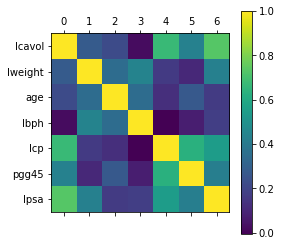

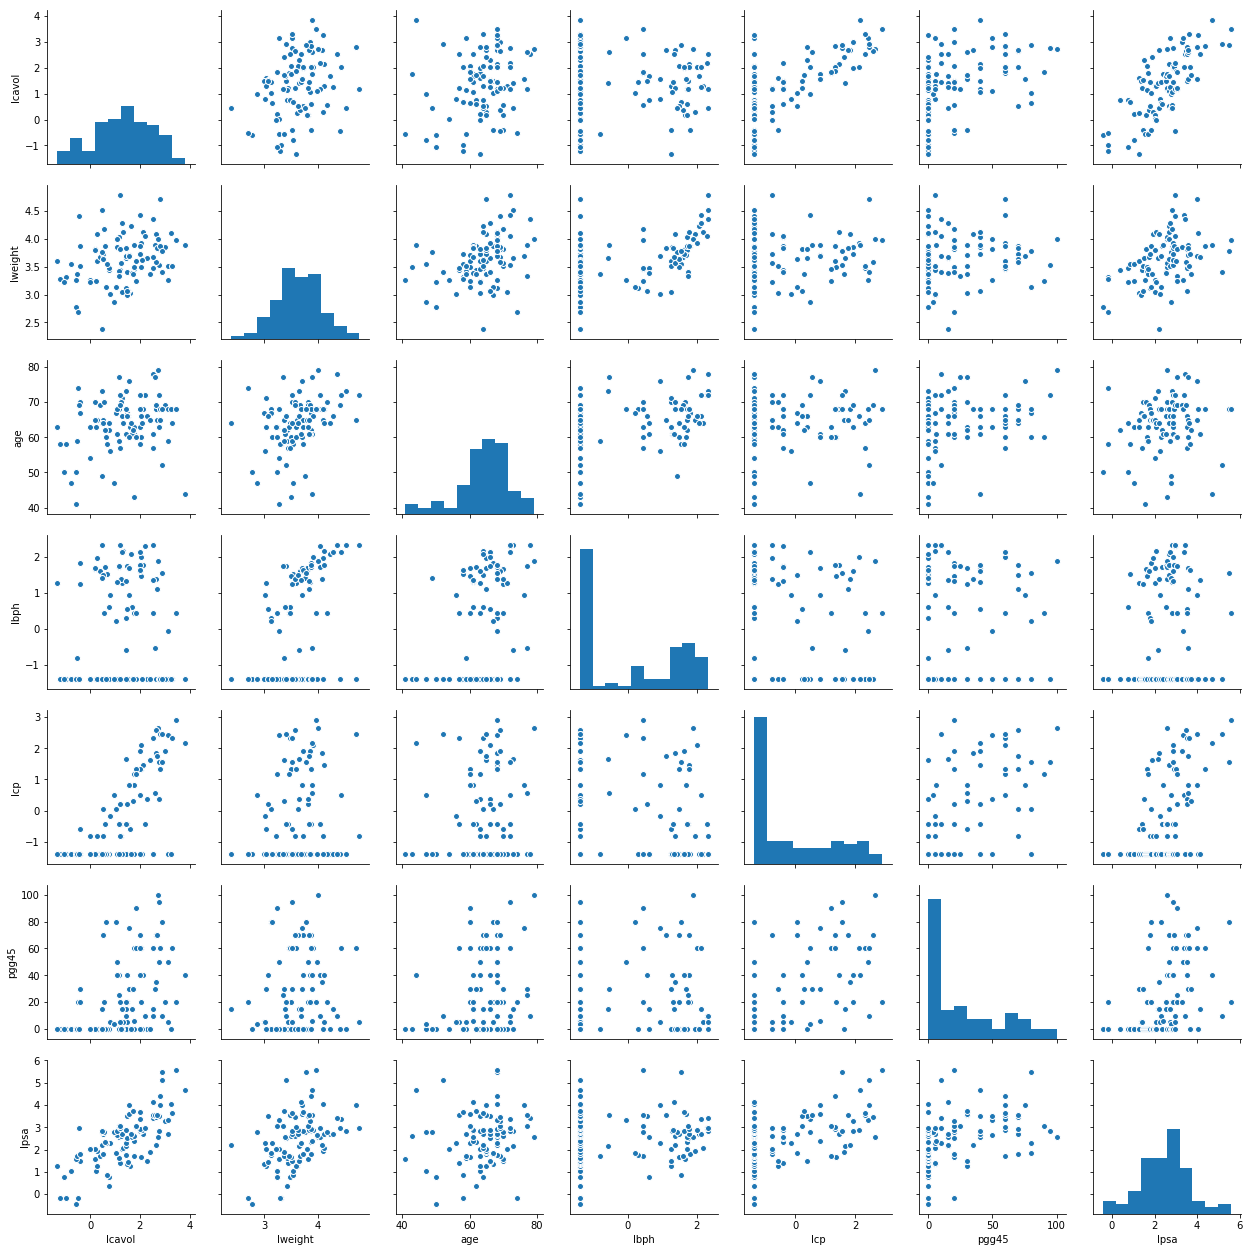

In [3]:
data_partial = data.drop(['svi', 'gleason'], axis=1, inplace=False) # Remove categorical columns
corr = data_partial.corr()
plt.matshow(corr) # Correlated features are colored yellow
plt.yticks(range(len(corr.columns)), corr.columns);
plt.colorbar()
sns.pairplot(data, vars=['lcavol', 'lweight', 'age', 'lbph', 'lcp', 'pgg45', 'lpsa']);

The above chart shows a visible correlation of lpsa with lcavol, lweights and lcp, leading us to expect higher regression coefficients against these explanatory variables.
In the case of lcp though, a significant cluster of values around -1 makes it difficult to draw conclusions.

### Perform linear regression on the full set

In [4]:
lr = sk.linear_model.LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
lr_mse = np.mean((y_pred - y) ** 2)
lr_r2 = sk.metrics.r2_score(y, y_pred)
print(f"MSE_full = {lr_mse:.3f}")
print(f"R2_full = {lr_r2:.3f}")
print("\nRegression coefficients:")
for name, value in zip(data.columns.values, lr.coef_):
    print(f"{name}: {value:.3f}")

MSE_full = 0.444
R2_full = 0.663

Regression coefficients:
lcavol: 0.564
lweight: 0.622
age: -0.021
lbph: 0.097
svi: 0.762
lcp: -0.106
gleason: 0.049
pgg45: 0.004


### Perform linear regression on the training set
Question: why is this relevant?

In [5]:
lr = sk.linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)

lr_mse_test = np.mean((y_test_pred - y_test) ** 2)
lr_mse_train = np.mean((y_train_pred - y_train) ** 2)
lr_r2 = sk.metrics.r2_score(y_test, y_test_pred)
lr_r2_train = sk.metrics.r2_score(y_train, y_train_pred)

print(f"MSE_test = {lr_mse_test:.3f}")
print(f"R2_test = {lr_r2:.3f}")
print(f"MSE_train = {lr_mse_train:.3f}")
print(f"R2_train = {lr_r2_train:.3f}")
print("Coefficients =", lr.coef_)

MSE_test = 2.821
R2_test = -4.558
MSE_train = 0.287
R2_train = 0.557
Coefficients = [ 0.41232826  0.51638253 -0.02561302  0.16083302 -0.77321563 -0.0949526
  0.32857241  0.0023484 ]


### Perform ridge regression

In [6]:
n_alphas = 500
coefs = []
errors = []
min_index = 0
epsilon = 0.002
alphas = np.logspace(-3, 5, base=10.0, num=n_alphas) # Values of hyperparameter `alpha`
ridge = sk.linear_model.Ridge()
for i in range(alphas.size):
    ridge.set_params(alpha=alphas[i])
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([lr_mse_test, np.mean((ridge.predict(X_test) - y_test)**2)]) # Base value and MSE for current alpha
    if errors[i][1] < errors[min_index][1]:
        min_index = i

Quasi-minimum MSE value: 1.9730124649487348
Minimum reached for alpha = 10.966805983368674 at index 252
Coefficients = [ 0.34355703  0.20112488 -0.02151506  0.1754084  -0.07270388 -0.068197
  0.16316689  0.00433419]


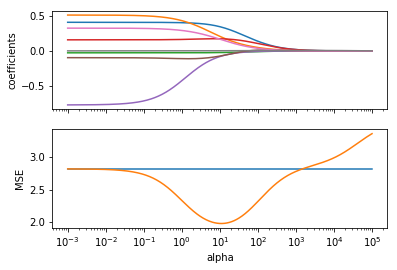

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
axes[0].set_xscale('log')
axes[0].set_ylabel('coefficients')
axes[0].plot(alphas, coefs);
axes[1].plot(alphas, errors);
axes[1].set_ylabel('MSE')
axes[1].set_xlabel('alpha');
print(f"Quasi-minimum MSE value: {errors[min_index][1]}")
print(f"Minimum reached for alpha = {alphas[min_index]} at index {min_index}")
print("Coefficients =", coefs[min_index])

### Run ridge regression with built-in cross validation

In [8]:
ridge = sk.linear_model.RidgeCV(alphas=alphas)
ridge.fit(X, y)
print(f"alpha = {ridge.alpha_}")
print("Intercept =", ridge.intercept_)
print(f"Error = {np.mean((ridge.predict(X_test) - y_test)**2)}")
print("\nRegression coefficients:")
for name, value in zip(data.columns.values, ridge.coef_):
    print(f"{name}: {value:.3f}")

alpha = 1.6689560099780232
Intercept = 0.4443140782841013
Error = 0.4724665767054628

Regression coefficients:
lcavol: 0.563
lweight: 0.561
age: -0.020
lbph: 0.099
svi: 0.643
lcp: -0.077
gleason: 0.034
pgg45: 0.005


### Perform LASSO regression

In [9]:
n_alphas = 500
coefs = []
errors = []
min_index = 0
epsilon = 0.01
alphas = np.logspace(-3, 3, base=10.0, num=n_alphas) # Values of hyperparameter `alpha`
lasso = sk.linear_model.Lasso()
for i in range(alphas.size):
    lasso.set_params(alpha=alphas[i])
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([lr_mse, np.mean((lasso.predict(X_test) - y_test)**2)]) # Base value and MSE for current alpha
    if errors[i][1] < errors[min_index][1] + epsilon:
        min_index = i

Minimum MSE value: 1.7492773731153335
Minimum reached for alpha = 0.056952267797128246 at index 146
Coefficients = [ 0.34676774  0.01974924 -0.01809244  0.17705144 -0.         -0.
  0.          0.00630203]


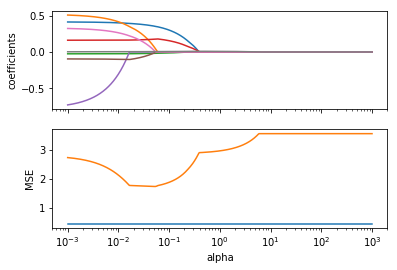

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
axes[0].set_xscale('log')
axes[0].set_ylabel('coefficients')
axes[0].plot(alphas, coefs);
axes[1].plot(alphas, errors);
axes[1].set_ylabel('MSE')
axes[1].set_xlabel('alpha');
print(f"Minimum MSE value: {errors[min_index][1]}")
print(f"Minimum reached for alpha = {alphas[min_index]} at index {min_index}")
print("Coefficients =", coefs[min_index])

In [11]:
lasso = sk.linear_model.LassoCV(alphas=alphas)
lasso.fit(X, y)
print(f"alpha = {lasso.alpha_}")
print("Intercept =", lasso.intercept_)
print(f"Error = {np.mean((lasso.predict(X) - y)**2)}")
print("\nRegression coefficients:")
for name, value in zip(data.columns.values, lasso.coef_):
    print(f"{name}: {value:.3f}")

alpha = 0.04439096531392171
Intercept = 1.0413328175846495
Error = 0.4766190278710474

Regression coefficients:
lcavol: 0.555
lweight: 0.366
age: -0.013
lbph: 0.085
svi: 0.298
lcp: 0.000
gleason: 0.000
pgg45: 0.005
